# Adversarial sequential games

## Nash equilibrium, Pareto-efficiency, zero-sum games

We start with a standard 2-player problem known as the [prisoner's dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) where two rational agents have to decide at the same time, i.e. without knowing the other's decision, whether they should cooperate or not. Their individual rewards depend on each other's decision, assuming each agent knows the other agent's reward model.

_<< The police offer each prisoner a Faustian bargain. If he testifies against his partner, he will go free while the partner will get three years in prison on the main charge. Oh, yes, there is a catch ... If both prisoners testify against each other, both will be sentenced to two years in jail. >>_

Here is the cost matrix, expressed as pairs of years in prison for each prisoner, depending on each prisoner's decision:

| | Prisoner B stays silent | Prisoner B testifies |
| --- | --- | --- |
| __Prisoner A stays silent__ | Each serves 1 year | Prisoner A: 3 years; Prisoner B: goes free |
| __Prisoner A stays A testifies__ | Prisoner A: goes free; Prisoner B: 3 years | Each serves 2 years |

![Prisoners dilemma](prisoners_dilemma.png)

Each prisoner wants to minimize the worst cost they could get, resulting here in each prisoner testifying against the other.

Therefore, each prisoner will serve 2 years in prison whereas they could have served 1 year each if they had cooperated.

### Nash Equilibrium

This solution is known as the __Nash equilibrium__ of the game which is defined for any non-cooperative game involving 2 or more players.

For a given player $i$, let's define $u_i(s_i,s^*_{-i})$ as the utility of the player where $s^*_{-i}$ denotes all the other players' strategies.

The _strategy profile_ $s^* = (s^*_i,s^*_{-i})$ is a _Nash equilibrium_ if: $u_i(s^*_i,s^*_{-i}) \geqslant u_i(s_i,s^*_{-i})$ for all $s_i \neq s^*_i$.

Said differently, a Nash equilibrium is a situation where no player can increase its own expected payoff by changing its strategy while the other players keep theirs unchanged.

A game can have zero or many _pure_ Nash equilibria, i.e. where each player deterministically makes its decision. However, each _finite_ game has a single _mixed_ Nash equilibrium, i.e. where each player probabilistically makes its decision.

In _zero-sum_ finite games, i.e. where the sum of players' payoffs equals $0$, there exists one (potentially mixed) Nash equilibrium which is equal to the _maximin_ decision: $u_i(s^*_i,s^*_{-i}) = \max_{s_i} \min_{s_{-i}} u_i(s_i,s_{-i})$.

### Pareto efficiency

__Pareto efficiency__ or __Pareto optimality__ is a situation where no player can increase its own expected payoff by changing its strategy without making another player's worse off.

In mathematical terms, it means that a $n$-agent strategy $(s_1,\cdots,s_n)$ is _Pareto-optimal_ if there is no other strategy $(s'_1,\cdots,s'_n)$ such that $u_i(s'_i,s'_{-i}) \geqslant u_i(s_i,s_{-i})$ for all $i$ and $u_i(s'_i,s'_{-i}) > u_i(s_i,s_{-i})$ for some $i$.

It is worth noting that Pareto-efficient solutions and Nash-equilibria do not need to coincide. While Pareto-optimality is rather sought when players cooperate, Nash-equilibrium concerns non-cooperative players who want to _individually_ maximize their payoffs by considering other players' potential actions. In the case of _zero-sum_ games, Nash equilibria correspond to non-cooperative solutions where each player does not only individually maximize their payoff, but they also want to minimize the potential damages imposed by the adversaries as _adversarial_ responses to their decisions (since some players cannot win without having some other players to lose).

![Pareto-optimality vs Nash equilibrium](pareto_optimality_vs_nash_equilibrium.png)

### Sequential games

A sequential game is a game where a set of players are taking decisions during many successive steps.

In a [_repeated game_](https://en.wikipedia.org/wiki/Repeated_game), such as the famous _rock-paper-scissors game_, the players always play the same game in sequence, meaning that the game has only state which is repeated in sequence.

In a [_combinatorial game_](https://en.wikipedia.org/wiki/Combinatorial_game_theory), such as the famous _tic-tac-toe game_, the state of the game is fully observable to all the agents and it can potentially change at each step.

In the remaining of this course, we will focus on _2-player combinatorial zero-sum games_, where:
- the game has many states that can change at each step ;
- the 2 players make decisions at each time step until reaching a terminal state of the game or after exhausting the horizon budget ;
- the 2 players either win or lose the game at the end of the game.
We will actually search for a sequence of [subgames' perfect equilibria](https://en.wikipedia.org/wiki/Subgame_perfect_equilibrium) by using backward induction.

<div class="alert alert-warning">
The following assumes perfect information and rational agents. If one of those two conditions are not met, the algorithms below won't necessarily produce winning strategies. We don't play the same strategies in chess in front of a master or a beginner player.
</div>

## Tic-Tac-Toe!

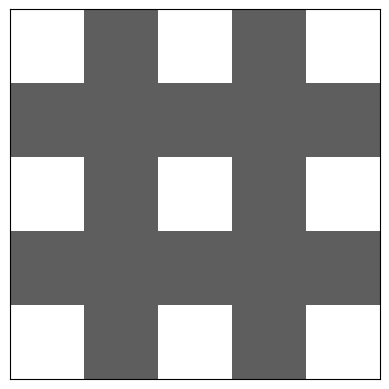

In [1]:
from copy import deepcopy
from enum import Enum
from typing import Any, NamedTuple, Tuple

import numpy as np
from numpy.typing import ArrayLike

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

TIC_TAC_TOE = """
 | | 
-----
 | | 
-----
 | | 
"""

class State:
    def __init__(self, array: ArrayLike):
        self._array = array
        
    def __hash__(self):
        return hash(tuple(self._array.astype(int).flatten()))
        
    def __eq__(self, other):
        return np.all(np.equal(self._array, other._array))
    
    def __str__(self):
        return str(self._array)
    
    def __repr__(self):
        return repr(self._array)
    
    @property
    def array(self):
        return self._array
    
    def copy(self):
        return State(self._array.copy())
    
class Player(Enum):
    CrossPlayer = 1
    CirclePlayer = 2
    
class Action(NamedTuple):
    x: int
    y: int

class TicTacToe:
    def __init__(self, tic_tac_toe_str: str = TIC_TAC_TOE):
        tic_tac_toe = []
        for y, line in enumerate(tic_tac_toe_str.split("\n")):
            row = []
            for c in line:
                if c == " ":
                    row.append(0)  # spaces are 0s
                else:
                    row.append(0.7)  # walls are 0.7s
            tic_tac_toe.append(row)
        self._tic_tac_toe = np.array(tic_tac_toe[1:-1], dtype=np.float32)
        self._ax = None
        self._fig = None
        self._image = None
        
    def reset(self):
        return State(np.zeros(shape=[3, 3], dtype=np.int32))
    
    def get_next_state(self, state: State, action: Tuple[Player, Action]) -> Tuple[State, float, bool]:
        assert state.array[action[1].x][action[1].y] == 0
        next_state = state.copy()
        next_state.array[action[1].x][action[1].y] = action[0].value
        if (np.asarray(np.prod(next_state.array, axis=0) == action[0].value**3).sum() > 0 or
            np.asarray(np.prod(next_state.array, axis=1) == action[0].value**3).sum() > 0 or
            np.prod(np.diagonal(next_state.array)) == action[0].value**3 or
            np.prod(np.diagonal(np.fliplr(next_state.array))) == action[0].value**3):
            return next_state, -2 * action[0].value + 3, True
        elif np.sum(np.asarray(next_state.array == 0).nonzero()) == 0:
            return next_state, 0, True
        else:
            return next_state, 0, False
    
    def render(self, state: State) -> Any:
        if self._ax is None:
            fig, ax = plt.subplots(1)
            #fig.canvas.set_window_title("tic-tac-toe")
            ax.set_aspect("equal")  # set the x and y axes to the same scale
            plt.xticks([])  # remove the tick marks by setting to an empty list
            plt.yticks([])  # remove the tick marks by setting to an empty list
            ax.invert_yaxis()  # invert the y-axis so the first row of data is at the top
            self._ax = ax
            self._fig = fig
            plt.ion()
        if self._image is None:
            self._image = self._ax.imshow(self._tic_tac_toe, cmap='Greys', vmin=0, vmax=1)
        else:
            self._image.set_data(self._tic_tac_toe)
        for row in range(3):
            for col in range(3):
                if state.array[row][col] == 1:
                    self._ax.scatter(2 * col, 2 * row, s=500, c='blue', marker='x')
                elif state.array[row][col] == 2:
                    self._ax.scatter(2 * col, 2 * row, s=500, facecolors='none', edgecolors='red')
        display(self._fig)
        clear_output(wait = True)
        plt.pause(1)
        
tic_tac_toe = TicTacToe()
tic_tac_toe.render(tic_tac_toe.reset())

## Minimax algorithm

The [minimax](https://en.wikipedia.org/wiki/Minimax) algorithm is used to find optimal non-cooperative 2-player strategies where
one player will try to maximize its own final score knowing that it will alternate with another player which will
try to minimize the first player's score.
The algorithm will then alternate maximization and minimization operations, hence its name.
Intuitively, the first player will try to maximize the minimum score it can get because of the other player trying
to make it lose the game.

![minimax](./img/Minimax.png)

First we need to define the tree structure that will alternate maximizing player nodes and minimizing player node.

In [7]:
from __future__ import annotations
from typing import Dict
from typing import Any, Tuple, List

class Tree:
    class Node:
        def __init__(self,
                     data: Any,
                     max_player: bool = True,
                     terminal: bool = False,
                     terminal_value: float = 0,
                     best_child: Tuple[Tree.Node, str] = None):
            self._data = data
            self._max_player = max_player
            self._terminal = terminal
            self._terminal_value = terminal_value
            self._best_child = best_child
            self._children: List[Tuple[Tree.Node, str]] = []
            
        @property
        def data(self):
            return self._data
        
        @property
        def max_player(self):
            return self._max_player
        
        @property
        def terminal(self):
            return self._terminal
        
        @property
        def terminal_value(self):
            return self._terminal_value
        
        @property
        def best_child(self):
            return self._best_child
        
        def __eq__(self, other: Tree.Node):
            return self._data.__eq__(other._data)
        
        def __hash__(self):
            return hash(self._data)
        
        def __str__(self):
            return str(self._data)
        
        def __repr__(self):
            return 'Node(data: {}, max_player: {}, terminal: {}, best child: {})'.format(
                repr(self._data),
                'true' if self._max_player else 'false',
                'true [{}]'.format(self._terminal_value) if self._terminal else 'false',
                repr(self._best_child[0]._data) if (self._best_child is not None and self._best_child[0] is not None) else None)
            
    def __init__(self):
        self._nodes: Dict[Any, Tree.Node] = {}
    
    def get_node(self, data: Any):
        if data not in self._nodes:
            self._nodes[data] = Tree.Node(data)
        return self._nodes[data]
        
    def get_children(self, node: Node) -> List[Tuple[Node, str]]:
        if node.data not in self._nodes or len(self._nodes[node.data]._children) == 0:
            if len(node._children) == 0:
                node._children = list(self.generate_children(node))
            assert all((c[0].max_player and not node.max_player) or
                       (not c[0].max_player and node.max_player)
                       for c in node._children)
            for c in node._children:
                self._nodes[c[0].data] = c[0]
            self._nodes[node.data] = node
        return self._nodes[node.data]._children
    
    def generate_children(self, node: Node) -> List[Tuple[Node, str]]:
        raise NotImplementedError
    
    def is_terminal(self, node: Node) -> bool:
        return node.terminal
    
    def render(self, node: Node) -> None:
        pass

Now, the code of the minimax algorithm, as described [there](https://en.wikipedia.org/wiki/Minimax#Pseudocode).

In [ ]:
from typing import Callable

def minimax(node : Tree.Node,
            tree: Tree,
            depth : int,
            maximizing_player : bool,
            evaluate : Callable[[Tree.Node], float]):
    ### WRITE YOUR CODE HERE
    # If you get stuck, uncomment the line in the next cell to load a solution.
    pass

In [4]:
# %load solutions/minimax.py

In [ ]:
class TicTacToeTree(Tree):
    def __init__(self, tic_tac_toe):
        super().__init__()
        self._tic_tac_toe = tic_tac_toe
    
    def generate_children(self, node: Tree.Node) -> List[Tuple[Tree.Node, str]]:
        state = node.data
        ### WRITE YOUR CODE HERE
        # If you get stuck, uncomment the line in the next cell to load a solution.
    
    def render(self, node: Tree.Node) -> None:
        self._tic_tac_toe.render(node.data)

In [6]:
# %load solutions/tic_tac_toe_tree.py

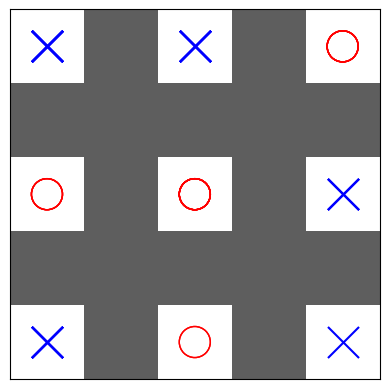

In [7]:
tic_tac_toe = TicTacToe(TIC_TAC_TOE)
tic_tac_toe_tree = TicTacToeTree(tic_tac_toe)

minimax(node=tic_tac_toe_tree.get_node(data=tic_tac_toe.reset()),
        tree = tic_tac_toe_tree,
        depth=1000,
        maximizing_player=True,
        evaluate = lambda n : n.terminal_value)

node = tic_tac_toe_tree.get_node(data=tic_tac_toe.reset())
tic_tac_toe.render(node.data)

while not node.terminal:
    # print('Action: {}'.format(node.best_child[1]))
    node = node.best_child[0]
    tic_tac_toe.render(node.data)

In [8]:
print(f'Terminal nodes: {len(set(n for n in tic_tac_toe_tree._nodes.values() if n.terminal))}')
print(f'Explored nodes: {len(tic_tac_toe_tree._nodes)}')

Terminal nodes: 983
Explored nodes: 5475


## Alpha-Beta Pruning

The [Alpha-Beta Pruning](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) algorithm is a popular optimal algorithm
to solve non-cooperative 2-player sequential games that improves over minimax by cutting search branches that are known to
be useless for one's player strategy to be improved.
To do so, the algorithm maintains maximum (_aka_ $\alpha$) and minimum (_aka_ $\beta$) values on, respectively, the maximizing
player's terminal score and the minimizing player's terminal score.
Those bounds allow the algorithm to stop exploring one player's node's subtrees (i.e. pruning the corresponding branches)
whenever the already discovered subtrees are sufficient to prove that the other player will necessarily choose a different option
than the one leading to the first player's node's.

![Alpha-Beta Pruning](img/AB_pruning.png)

The pseudocode of the Alpha-Beta Pruning algorithm is described [there](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning#Pseudocode).

In [ ]:
from typing import Callable

def alphabeta(node : Tree.Node,
              tree: Tree,
              depth : int,
              alpha : float,
              beta : float,
              maximizing_player : bool,
              evaluate : Callable[[Tree.Node], float]):
    ### WRITE YOUR CODE HERE
    # If you get stuck, uncomment the line in the next cell to load a solution.
    pass

In [10]:
# %load solutions/alphabeta.py

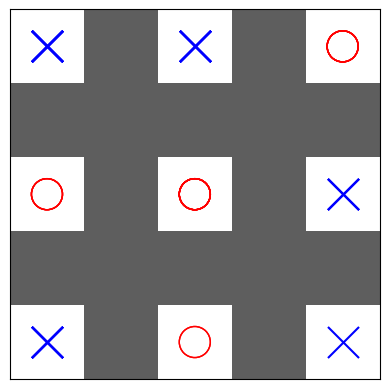

In [19]:
tic_tac_toe = TicTacToe(TIC_TAC_TOE)
tic_tac_toe_tree = TicTacToeTree(tic_tac_toe)

alphabeta(node=tic_tac_toe_tree.get_node(data=tic_tac_toe.reset()),
          tree = tic_tac_toe_tree,
          depth=1000,
          alpha=-float("inf"),
          beta=float("inf"),
          maximizing_player=True,
          evaluate = lambda n : n.terminal_value)

node = tic_tac_toe_tree.get_node(data=tic_tac_toe.reset())
tic_tac_toe.render(node.data)

while not node.terminal:
    # print('Action: {}'.format(node.best_child[1]))
    node = node.best_child[0]
    tic_tac_toe.render(node.data)

In [12]:
print(f'Terminal nodes: {len(set(n for n in tic_tac_toe_tree._nodes.values() if n.terminal))}')
print(f'Explored nodes: {len(tic_tac_toe_tree._nodes)}')

Terminal nodes: 710
Explored nodes: 3671


## Playing against a random player

In [ ]:
import random

tic_tac_toe = TicTacToe(TIC_TAC_TOE)
tic_tac_toe_tree = TicTacToeTree(tic_tac_toe)

def call_alphabeta_pruning(tic_tac_toe_tree: TicTacToeTree,
                           node: Tree.Node) -> None:
    alphabeta(node=node,
              tree = tic_tac_toe_tree,
              depth=1000,
              alpha=-float("inf"),
              beta=float("inf"),
              maximizing_player=True,
              evaluate = lambda n : n.terminal_value)
    
def call_random_player(tic_tac_toe_tree: TicTacToeTree,
                       node: Tree.Node) -> None:
    ### WRITE YOUR CODE HERE
    # If you get stuck, uncomment the line in the next cell to load a solution.
    pass

node = tic_tac_toe_tree.get_node(data=tic_tac_toe.reset())
tic_tac_toe.render(node.data)

while not node.terminal:
    ### WRITE YOUR CODE HERE
    # If you get stuck, uncomment the line in the next cell to load a solution.
        
    node = node.best_child[0]
    tic_tac_toe.render(node.data)

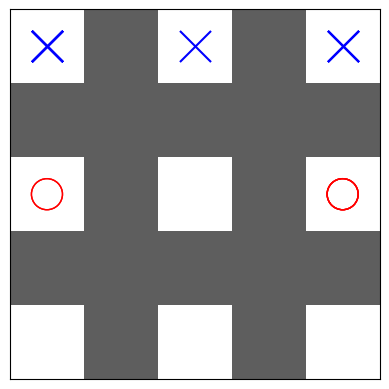

In [21]:
# %load solutions/alphabeta_vs_random.py

## Playing _optimally_ against a random player

Since we know that the opponent is playing randomly, we can exploit the knowledge of its policy to optimize our own strategy.
For this, we can model our own process choice as a Markov Decision Process and solve the game _from our perspective_ by using
an MDP algorithm like RTDP.
We will use [scikit-decide](https://github.com/airbus/scikit-decide) to model and solve the problem.

In [ ]:
from enum import Enum
from typing import *

from skdecide import *
from skdecide.builders.domain import *
from skdecide.hub.space.gym import ListSpace

class D(MDPDomain, Goals, Renderable):
    T_state = Tree.Node  # Type of states
    T_observation = T_state  # Type of observations
    T_event = Tuple[Tree.Node, str]  # Type of events/actions
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class ProbabilisticGameDomain(D):
    
    def __init__(self,
                 game_tree: Tree,
                 root_node: Tree.Node,
                 opponent_policy: Callable[[Tree.Node],
                                           List[Tuple[float, Tree.Node]]],
                 max_or_min_player: bool = True):
        self._game_tree = game_tree
        self._game_root_node = root_node
        self._opponent_policy = opponent_policy
        self._max_or_min_player = max_or_min_player
    
    def _is_terminal(self, state: D.T_state) -> D.T_predicate:
        return self._game_tree.is_terminal(state)
    
    def _get_transition_value(self, memory: D.T_state, action: D.T_event, next_state: Optional[D.T_state] = None) -> Value[D.T_value]:
        ### WRITE YOUR CODE HERE
        # If you get stuck, uncomment the line in the next cell to load a solution.
        pass
    
    def _get_next_state_distribution(self, memory: D.T_state, action: D.T_event) -> DiscreteDistribution[D.T_state]:
        ### WRITE YOUR CODE HERE
        # If you get stuck, uncomment the line in the next cell to load a solution.
        pass
    
    def _get_action_space_(self) -> Space[D.T_event]:
        pass
    
    def _get_applicable_actions_from(self, memory: D.T_state) -> Space[D.T_event]:
        ### WRITE YOUR CODE HERE
        # If you get stuck, uncomment the line in the next cell to load a solution.
        pass
    
    def _get_goals_(self) -> Space[D.T_observation]:
        return ImplicitSpace(lambda s: self._game_tree.is_terminal(s))
    
    def _get_initial_state_(self) -> D.T_state:
        return self._game_root_node
    
    def _get_observation_space_(self) -> Space[D.T_observation]:
        pass
    
    def _render_from(self, memory: D.T_state, **kwargs: Any) -> Any:
        self._game_tree.render(memory)

In [23]:
# %load solutions/probabilistic_game_domain.py

Let's use LRTDP from `scikit-decide` as our MDP solver, as described in Algorthm 1 in [this paper](https://ftp.cs.ucla.edu/pub/stat_ser/R319.pdf).

In [ ]:
import random
from skdecide.hub.solver.lrtdp import LRTDP

tic_tac_toe = TicTacToe(TIC_TAC_TOE)
tic_tac_toe_tree = TicTacToeTree(tic_tac_toe)

def call_game_rtdp(tree: Tree,
                   node: Tree.Node,
                   opponent_policy: Callable[[Tree.Node],
                                             List[Tuple[float, Tree.Node]]],
                   max_value: float) -> None:
    domain_factory = lambda: ProbabilisticGameDomain(tree, node, opponent_policy)
    rtdp_factory = lambda: LRTDP(
        domain_factory=domain_factory,
        heuristic = lambda d, s : Value(reward=max_value),
        discount=1.0,
        epsilon=0.001,
        parallel=False,
        debug_logs=False)
    with rtdp_factory() as rtdp:
        rtdp.solve()
        node._best_child = rtdp.sample_action(node)
    
def call_random_player(tic_tac_toe_tree: TicTacToeTree,
                       node: Tree.Node) -> None:
    node._best_child = random.sample(tic_tac_toe_tree.get_children(node), 1)[0]
    
def random_player_policy(node: Tree.Node) -> List[Tuple[float, Tree.Node]]:
    ### WRITE YOUR CODE HERE
    # If you get stuck, uncomment the line in the next cell to load a solution.
    pass

node = tic_tac_toe_tree.get_node(data=tic_tac_toe.reset())
tic_tac_toe.render(node.data)

while not node.terminal:
    if node.max_player:
        call_game_rtdp(tic_tac_toe_tree, node, random_player_policy, 1)
    else:
        call_random_player(tic_tac_toe_tree, node)
        
    node = node.best_child[0]
    tic_tac_toe.render(node.data)

[2025-06-25 11:47:19.024] [info] Running sequential LRTDP solver from state [[1 0 1]
 [0 0 2]
 [0 0 2]]
[2025-06-25 11:47:19.025] [info] LRTDP finished to solve from state [[1 0 1]
 [0 0 2]
 [0 0 2]] in 0 seconds with 1 rollouts and visited 18 states. 
[2025-06-25 11:47:19.025] [info] Running sequential LRTDP solver from state [[1 0 1]
 [0 0 2]
 [0 0 2]]
[2025-06-25 11:47:19.025] [info] LRTDP finished to solve from state [[1 0 1]
 [0 0 2]
 [0 0 2]] [solved state]


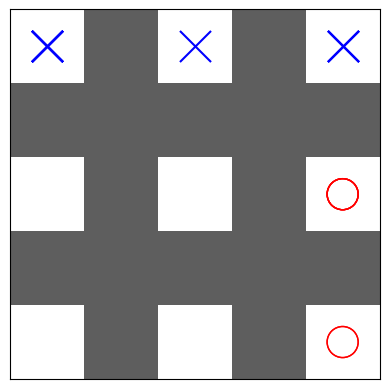

In [27]:
# %load solutions/rtdp_vs_random.py

## Back to epic combats: RTDP vs RTDP!

In [ ]:
tic_tac_toe = TicTacToe(TIC_TAC_TOE)
tic_tac_toe_tree = TicTacToeTree(tic_tac_toe)

def opponent_policy(tree_node: Tree.Node,
                    opponent_pol: Dict[Tree.Node,
                                       Tuple[Tuple[Tree.Node, str], float]]) -> List[Tuple[float, Tree.Node]]:
    ### WRITE YOUR CODE HERE
    # If you get stuck, uncomment the line in the next cell to load a solution.
    pass

def call_game_rtdp(tree: Tree,
                   node: Tree.Node,
                   opponent_pol: Dict[Tree.Node,
                                      Tuple[Tuple[Tree.Node, str], float]],
                   max_value: float,
                   max_or_min_player: bool) -> None:
    domain_factory = lambda: ProbabilisticGameDomain(tree,
                                                     node,
                                                     lambda tree_node: opponent_policy(tree_node, opponent_pol),
                                                     max_or_min_player)
    rtdp_factory = lambda: LRTDP(
        domain_factory=domain_factory,
        heuristic = lambda d, s : Value(reward=max_value) if max_or_min_player else Value(cost=max_value),
        discount=1.0,
        epsilon=0.001,
        parallel=False,
        debug_logs=False)
    with rtdp_factory() as rtdp:
        rtdp.solve()
        node._best_child = rtdp.sample_action(node)
        policy = rtdp.get_policy()
    
    return policy

node = tic_tac_toe_tree.get_node(data=tic_tac_toe.reset())
tic_tac_toe.render(node.data)
current_opponent_policy = None

while not node.terminal:
    print('Player {}\'s turn'.format(
        'Cross' if node.max_player else 'Circle'
    ))
    current_opponent_policy = call_game_rtdp(
        tic_tac_toe_tree,
        node,
        current_opponent_policy,
        1,
        node.max_player
    )
    
    node = node.best_child[0]
    tic_tac_toe.render(node.data)

In [ ]:
# %load solutions/rtdp_vs_rtdp.py

## Probabilistic Sequential game

We now consider the case of stochastic games, where the effects of each player's actions are noised after each time step.

Let's first implement a probabilistic tree which can model this behaviour during the search for the best strategy.

In [28]:
from __future__ import annotations

class ProbabilisticTree:
    class StateNode:
        def __init__(
            self,
            data: Any,
            max_player: bool = True,
            terminal: bool = False,
            terminal_value: float = 0,
            best_child: Tuple[ProbabilisticTree.ActionNode, str] = None,
        ):
            self._data = data
            self._max_player = max_player
            self._terminal = terminal
            self._terminal_value = terminal_value
            self._best_child = best_child
            self._children: List[Tuple[ProbabilisticTree.ActionNode, str]] = []

        @property
        def data(self):
            return self._data

        @property
        def max_player(self):
            return self._max_player

        @property
        def terminal(self):
            return self._terminal

        @property
        def terminal_value(self):
            return self._terminal_value

        @property
        def best_child(self):
            return self._best_child

        def __eq__(self, other: Tree.StateNode):
            return self._data.__eq__(other._data)

        def __hash__(self):
            return hash(self._data)

        def __str__(self):
            return str(self._data)

        def __repr__(self):
            return (
                "Node(data: {}, max_player: {}, terminal: {}, best child: {})".format(
                    repr(self._data),
                    "true" if self._max_player else "false",
                    (
                        "true [{}]".format(self._terminal_value)
                        if self._terminal
                        else "false"
                    ),
                    (
                        repr(self._best_child[0]._data)
                        if (
                            self._best_child is not None
                            and self._best_child[0] is not None
                        )
                        else None
                    ),
                )
            )

    class ActionNode:
        def __init__(self, data: Any) -> None:
            self._children: List[
                Tuple[ProbabilisticTree.StateNode, str, float]
            ] = []

        @property
        def data(self):
            return self._data

        def __eq__(self, other: ProbabilisticTree.ActionNode):
            return self._data.__eq__(other._data)

        def __hash__(self):
            return hash(self._data)

        def __str__(self):
            return str(self._data)

        def __repr__(self):
            return "Node(data: {})".format(repr(self._data))

    def __init__(self):
        self._nodes: Dict[Any, ProbabilisticTree.StateNode] = {}

    def get_node(self, data: Any):
        if data not in self._nodes:
            self._nodes[data] = ProbabilisticTree.StateNode(data)
        return self._nodes[data]

    def get_children(
        self, node: ProbabilisticTree.StateNode
    ) -> List[Tuple[ProbabilisticTree.ActionNode, str]]:
        if node.data not in self._nodes or len(self._nodes[node.data]._children) == 0:
            if len(node._children) == 0:
                node._children = list(self.generate_children(node))
            assert all(
                (cc[0].max_player and not node.max_player)
                or (not cc[0].max_player and node.max_player)
                for c in node._children for cc in c[0]._children
            )
            for c in node._children:
                for cc in c[0]._children:
                    self._nodes[cc[0].data] = cc[0]
            self._nodes[node.data] = node
        return self._nodes[node.data]._children

    def generate_children(
        self, node: ProbabilisticTree.StateNode
    ) -> List[Tuple[ProbabilisticTree.ActionNode, str]]:
        raise NotImplementedError

    def is_terminal(self, node: ProbabilisticTree.StateNode) -> bool:
        return node.terminal

    def render(self, node: ProbabilisticTree.StateNode) -> None:
        pass

Now, we define a probabilistic version of the tic-tac-toe game where the position $(x, y)$ chosen by a player at a given point in time can be randomly changed to the mirror position $(y, x)$ if the latter is free in the board.

In [29]:
class ProbabilisticTicTacToeTree(ProbabilisticTree):
    def __init__(self, tic_tac_toe):
        super().__init__()
        self._tic_tac_toe = tic_tac_toe

    def generate_children(self, node: ProbabilisticTree.StateNode) -> List[Tuple[ProbabilisticTree.ActionNode, str]]:
        state = node.data
        avail_posx, avail_posy = np.asarray(state.array == 0).nonzero()
        for i in range(len(avail_posx)):
            succs = [(avail_posx[i], avail_posy[i])]
            if (avail_posy[i], avail_posx[i]) in [(avail_posx[ii], avail_posy[ii]) for ii in range(len(avail_posx))]:
                succs.append((avail_posy[i], avail_posx[i]))
            nsuccs = []
            for s in succs:
                next_state, value, terminal = self._tic_tac_toe.get_next_state(
                    state,
                    (
                        (
                            Player.CrossPlayer
                            if node.max_player
                            else Player.CirclePlayer
                        ),
                        Action(
                            x=s[0],
                            y=s[1],
                        ),
                    ),
                )
                nsuccs.append((next_state, value, terminal, s[0], s[1]))
            action_node = ProbabilisticTree.ActionNode(data=nsuccs[0][0])
            action_node._children = [
                (
                    ProbabilisticTree.StateNode(
                        data=s[0],
                        max_player=not node.max_player,
                        terminal=s[2],
                        terminal_value=s[1],
                    ),
                    "{} at ({}, {})".format(
                        "cross" if node.max_player else "circle",
                        str(s[3]),
                        str(s[4]),
                    ),
                    1. / len(nsuccs)
                )
                for s in nsuccs
            ]
            yield (
                action_node,
                "{} at ({}, {})".format(
                    "cross" if node.max_player else "circle",
                    str(avail_posx[i]),
                    str(avail_posy[i]),
                ),
            )

    def render(self, node: Tree.Node) -> None:
        self._tic_tac_toe.render(node.data)

This kind of zero-sum games with stochastic action effects can be solved by a probabilistic extension of the _minimax_ algorithm named [_expectiminimax_](https://en.wikipedia.org/wiki/Expectiminimax). In the expectiminimax algorithm presented in Wikipedia, actions do no need to be all stochastic. We propose below a version of the algorithm which is simpler to implement while being more general, where we assume that each action effect is stochastic (yet potentially with a single outcome).

In [ ]:
from typing import Callable

def expectiminimax(
    node: ProbabilisticTree.StateNode,
    tree: ProbabilisticTree,
    depth: int,
    maximizing_player: bool,
    evaluate: Callable[[ProbabilisticTree.StateNode], float],
):
    if depth == 0 or tree.is_terminal(node):
        return evaluate(node)
    if maximizing_player:
        value = -float("inf")
        for child in tree.get_children(node):
            ### WRITE YOUR CODE HERE
            # If you get stuck, uncomment the line in the next cell to load a solution.
            if tentative >= value:
                node._best_child = child
                value = tentative
        return value
    else:
        value = float("inf")
        for child in tree.get_children(node):
            ### WRITE YOUR CODE HERE
            # If you get stuck, uncomment the line in the next cell to load a solution.
            if tentative <= value:
                node._best_child = child
                value = tentative
        return value

In [31]:
# %load solutions/expectiminimax.py

Let's give it a try!

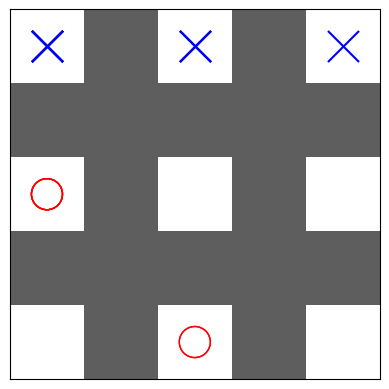

In [38]:
tic_tac_toe = TicTacToe(TIC_TAC_TOE)
tic_tac_toe_tree = ProbabilisticTicTacToeTree(tic_tac_toe)

node = tic_tac_toe_tree.get_node(data=tic_tac_toe.reset())
tic_tac_toe.render(node.data)

while not node.terminal:

    if node.best_child is None:
        expectiminimax(node=node,
              tree = ProbabilisticTicTacToeTree(tic_tac_toe),
              depth=4,
              maximizing_player=True,
              evaluate = lambda n : n.terminal_value
        )
    
    action_node = node.best_child[0]
    node = random.choices(
        population=[cc[0] for cc in action_node._children],
        weights=[cc[2] for cc in action_node._children],
        k=1,
    )[0]
    tic_tac_toe.render(node.data)

## Trying a more difficult game: connect-4

In [9]:
from muzero.games.connect4 import Connect4

connect4 = Connect4()
connect4.render()

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [ ]:
import numpy as np

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class Board:
    def __init__(self, board: ArrayLike):
        self._board = board
        
    def __hash__(self):
        return hash(tuple(self._board.astype(int).flatten()))
        
    def __eq__(self, other):
        return np.all(np.equal(self._board, other._board))
    
    def __str__(self):
        return str(self._board)
    
    def __repr__(self):
        return repr(self._board)
    
    @property
    def board(self):
        return self._board
    
    def copy(self):
        return Board(self._board.copy())
    

class Connect4Tree(Tree):
    # We will store the Connect4 boards in the tree nodes
    # I.e: Tree.Node._data is a Board (i.e. hashable numpy array) as defined in the Connect4 class
            
    def __init__(self):
        super().__init__()
        self._ax = None
        self._fig = None
        self._image = None
    
    def reset(self) -> Tree.Node:
        connect4 = Connect4()
        connect4.reset()
        return self.get_node(data=Board(connect4.board))
    
    def generate_children(self, node: Tree.Node) -> List[Tuple[Tree.Node, str]]:
        connect4 = Connect4()
        connect4.board = node.data.board
        ### WRITE YOUR CODE HERE
        # If you get stuck, uncomment the line in the next cell to load a solution.
    
    def render(self, node: Tree.Node) -> None:
        board_to_render = np.zeros(shape=(2 * node.data.board[::-1].shape[0] + 1,
                                          2 * node.data.board[::-1].shape[1] + 1),
                                   dtype=np.float32)
        
        for r in range(int(board_to_render.shape[0] / 2) + 1):
            board_to_render[2*r,:] = 0.7 * np.ones(board_to_render.shape[1])
        for c in range(int(board_to_render.shape[1] / 2) + 1):
            board_to_render[:,2*c] = 0.7 * np.ones(board_to_render.shape[0])
            
        if self._ax is None:
            fig, ax = plt.subplots(1)
            fig.canvas.set_window_title("connect-4")
            ax.set_aspect("equal")  # set the x and y axes to the same scale
            plt.xticks([])  # remove the tick marks by setting to an empty list
            plt.yticks([])  # remove the tick marks by setting to an empty list
            ax.invert_yaxis()  # invert the y-axis so the first row of data is at the top
            self._ax = ax
            self._fig = fig
            plt.ion()
        if self._image is None:
            self._image = self._ax.imshow(board_to_render, cmap='Greys', vmin=0, vmax=1)
        else:
            self._image.set_data(board_to_render)
        
        for r in range(node.data.board[::-1].shape[0]):
            for c in range(node.data.board[::-1].shape[1]):
                if node.data.board[::-1][r,c] == 1:
                    self._ax.scatter(2*c + 1, 2*r + 1, facecolors='green', edgecolors='green')
                elif node.data.board[::-1][r,c] == -1:
                    self._ax.scatter(2*c + 1, 2*r + 1, facecolors='red', edgecolors='red')
        
        display(self._fig)
        clear_output(wait = True)
        plt.pause(1)

connect4_tree = Connect4Tree()
connect4_tree.render(connect4_tree.reset())

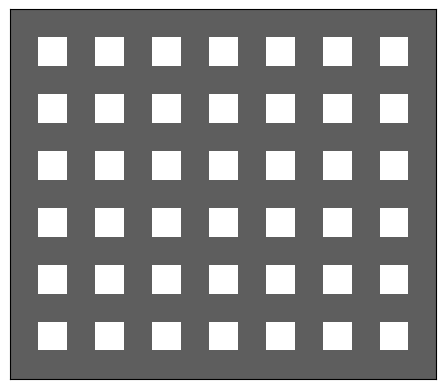

In [10]:
# %load solutions/connect4_tree.py

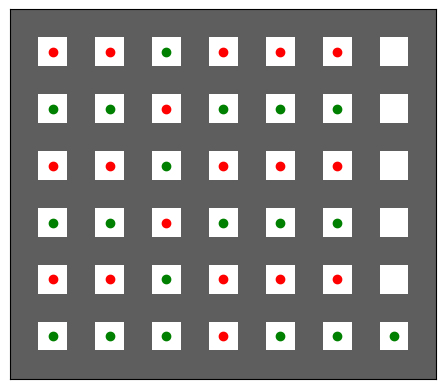

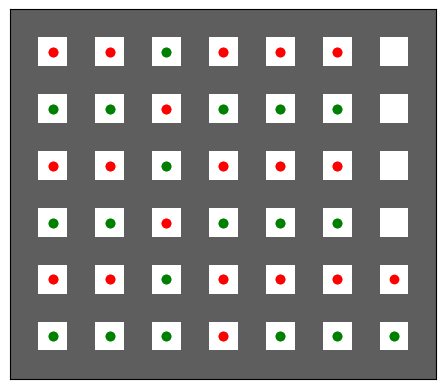

In [42]:
connect4_tree = Connect4Tree()

node = connect4_tree.reset()
connect4_tree.render(node)

while not node.terminal:
    
    solve = False
    if node.best_child is None:
        solve = True
        connect4_tree = Connect4Tree()
        alphabeta(node=node,
              tree = connect4_tree,
              depth=6,
              alpha=-float("inf"),
              beta=float("inf"),
              maximizing_player=True,
              evaluate = lambda n : n.terminal_value
        )
    
    node = node.best_child[0]
    connect4_tree.render(node)

### MuZero

[MuZero](https://www.deepmind.com/blog/muzero-mastering-go-chess-shogi-and-atari-without-rules) is a popular algorithm for optimizing
non-cooperative 2-player sequential games using [Monte-Carlo Tree Search](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search)
and deep-learning.
Like when we tried to play RTDP against itself, MuZero will learn a playing strategy in the form of a deep neural network policy
by learning to play against itself.

![MCTS](img/MCTS.png)

![MuZero](img/muzero.gif)

In [ ]:
%cd muzero/
!pip install -r requirements.txt
#!pip uninstall -y pyarrow
%load_ext tensorboard
%cd ..

In [11]:
%tensorboard --logdir ./muzero/results

In [ ]:
#%cd muzero/
#!python muzero.py connect4 '{"training_steps": 100}'
#%cd ..

import os
current_dir = os.path.abspath('')
muzero_dir = os.path.join(current_dir, 'muzero')
%env PYTHONPATH=$muzero_dir:$current_dir

import sys
sys.path.append(muzero_dir)
sys.path.append(current_dir)

from muzero import MuZero
from games.connect4 import MuZeroConfig, Game

config = MuZeroConfig()
config.training_steps = 100
muzero = MuZero('connect4', config)
muzero.train()

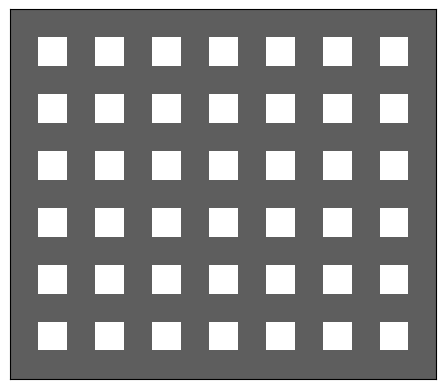

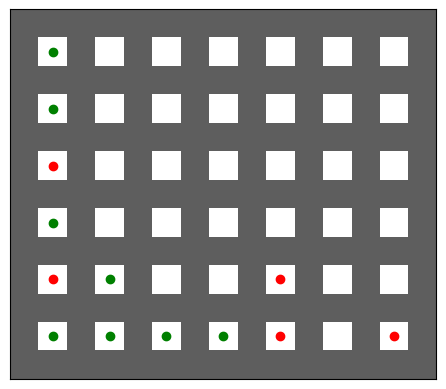

In [16]:
import os
import torch
current_dir = os.path.abspath('')
muzero_dir = os.path.join(current_dir, 'muzero')
%env PYTHONPATH=$muzero_dir:$current_dir

import sys
sys.path.append(muzero_dir)
sys.path.append(current_dir)

from muzero import MuZero
from games.connect4 import MuZeroConfig, Game

config = MuZeroConfig()
config.training_steps = 100
muzero = MuZero('connect4', config)

muzero.load_model(checkpoint_path = os.path.join(muzero_dir, "results/connect4/2025-06-25--13-59-36/model.checkpoint"))
result, results = muzero.test(render=False)
current_action = 0
connect4_tree = Connect4Tree()

node = connect4_tree.reset()
connect4_tree.render(node)

while not node.terminal:

    connect4.player =  2 * int(node.max_player) -1
    obs, reward, done = connect4.step(results[0].action_history[current_action])
    current_action += 1
    next_board = connect4.board.copy()
    
    node = Tree.Node(
        data=Board(next_board),  # obs is not what we want here
        max_player=not node.max_player,
        terminal=done,
        terminal_value=reward if done else 0
    )
    connect4_tree.render(node)